## Final Project: Analyzing Amazon Reviews
## Student: Chip Nguyen (COSC74)

People I discussed with: Professor SouYoung Jin, Vaani, Mia 

### 1. Import training data

In [1]:
import pandas as pd
import numpy as np
import warnings
from warnings import simplefilter
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
simplefilter(action='ignore')

%matplotlib inline

In [2]:
data = pd.read_csv("Training.csv")
df = pd.DataFrame(data)

### Pre-process reviewText and summary using TF-IDF vectorizer
The features that I am using to train the model are the reviewText and summary. This section preprocesses the two variables using TF-IDF vectorizer. The process is as following:

1. Convert texts to lower case
2. Remove punctuations
3. Vectorize using TF-IDF vectorizer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Convert reviewText and summary to lower case
df.loc[:, 'reviewText'] = df['reviewText'].str.lower()
df.loc[:, 'summary'] = df['summary'].str.lower()

# Remove punctuations for reviewText and summary
df['reviewText']=df['reviewText'].str.replace('[^\w\s]','')
df['summary']=df['summary'].str.replace('[^\w\s]','')

In [5]:
# Vectorize reviewText
vectorizer1 = TfidfVectorizer(stop_words = 'english', min_df = 5, max_features = 2000)
vectorizedReview = vectorizer1.fit_transform(df['reviewText']).toarray()

In [6]:
# Vectorize summaryText
vectorizer2 = TfidfVectorizer(stop_words = 'english', min_df = 5, max_features = 1500)
vectorizedSummary = vectorizer2.fit_transform(df['summary'].values.astype('U')).toarray()

In [7]:
#Vectorized feature used for training
vectorizedFeature = np.concatenate((vectorizedReview, vectorizedSummary), axis =1)

### 2. Models for Classification
For my classification tasks, I will use the three following classification algorithms:
1. Logistic Regression
2. Multinomial Naive Bayes
3. Perceptron

To tune the parameters for my models, I will use GridSearchCV. For each classification task, the best model will be the one with the highest validation score. This best model for each task will then go through testing by submitting predictions to the Kaggle competitions.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import train_test_split

# Import metrics from sklearn
from sklearn.metrics import RocCurveDisplay, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score

### 2.1. Binary Classifier 1: 'overall' = 1 versus 'overall' > 1

In [16]:
# Assign X
X = vectorizedFeature

In [17]:
# 'overall' = 1 labeled as 0, 'overall' > 0 labelled as 1
df1 = df['overall'].replace([1,2,3,4,5], [0,1,1,1,1])
y1 = df1.to_numpy()

In [18]:
# Split data for validation after hyperparameter tuning
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.2, train_size = 0.8)

#### Logistic Regression

In [ ]:
# Logistic Regression using linear regression
logistic1 = LogisticRegression(solver = "liblinear")

# Parameter grid for hyper-parameter tuning
para_grid_log1 = [
    {'penalty': ['l1','l2', 'none'],
     'C': [100, 10, 1.0, 0.1],
    'max_iter': [500, 1000, 5000]
    }
]

# Set hyper-parameter tuning using 5-fold cross-validation
clf_log1 = GridSearchCV(logistic1, param_grid = para_grid_log1, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_log1 = clf_log1.fit(X, y1)

# Print best average 5-fold cross-validation score and the hyperparameters associated with it
print(best_clf_log1.best_score_, best_clf_log1.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.7537840233382237 LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')


In [ ]:
# Print mean cross-validation score
df_best = pd.DataFrame(best_clf_log1.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.7234095908903408


F1: 0.7643485958695856
Accuracy: 0.868276807125728


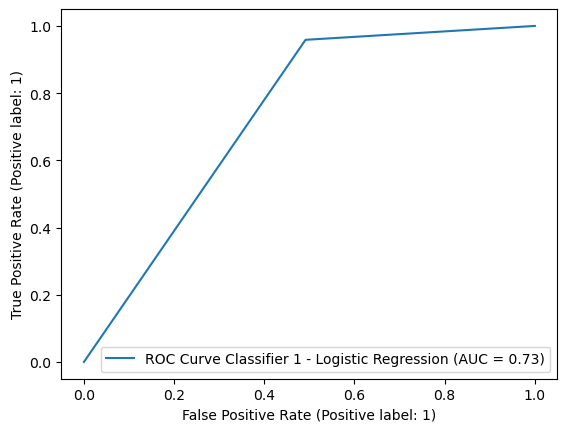

In [ ]:
# Model using the trained hyperparameters
logistic_best1 = best_clf_log1.best_estimator_

# Fit the model using X_train and y1_train
logistic_best1.fit(X_train, y1_train)

# Predict the labels for test set, find the ROC curve and ROC AUC score
y_predicted = logistic_best1.predict(X_test)

RocCurveDisplay.from_predictions(y1_test, y_predicted, name = "ROC Curve Classifier 1 - Logistic Regression")
print("F1: " + str(f1_score(y1_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y1_test, y_predicted)))

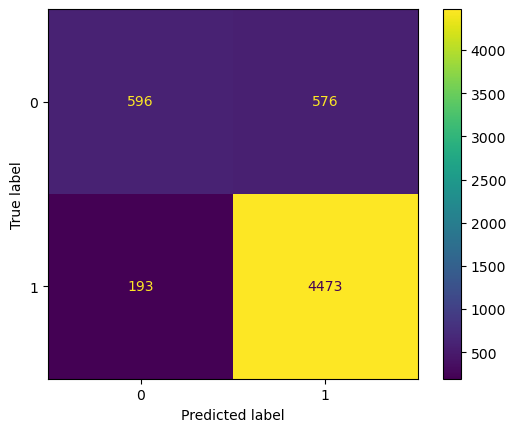

In [ ]:
ConfusionMatrixDisplay.from_predictions(y1_test, y_predicted)

#### Perceptron

In [ ]:
pct1 = Perceptron()

para_grid_pct1 = [
    {'penalty': ['l2','l1', 'elasticnet'],
     'l1_ratio': [0, 0.1, 0.5, 1],
     'max_iter': [500, 1000]}
]

clf_pct1 = GridSearchCV(pct1, param_grid = para_grid_pct1, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_pct1 = clf_pct1.fit(X, y1)

print(best_clf_pct1.best_score_, best_clf_pct1.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.7064834533019285 Perceptron(l1_ratio=0, max_iter=500, penalty='l2')


In [ ]:
df_best = pd.DataFrame(best_clf_pct1.cv_results_)
df_best.loc[:, 'mean_test_score'].mean()

0.7035699352752921

F1: 0.7226162105371052
Accuracy: 0.8475505310037684


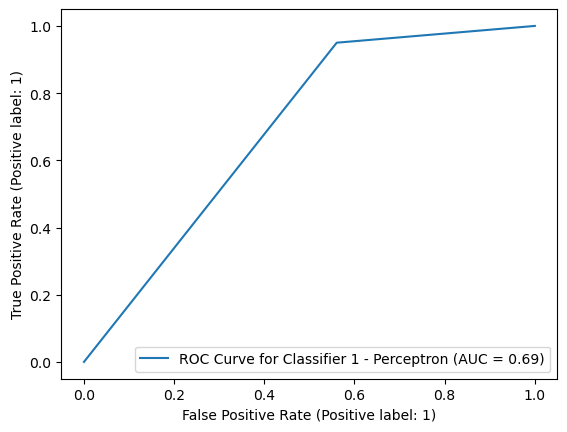

In [ ]:
pct_best1 = best_clf_pct1.best_estimator_
pct_best1.fit(X_train, y1_train)
y_predicted = pct_best1.predict(X_test)

RocCurveDisplay.from_predictions(y1_test, y_predicted, name = "ROC Curve for Classifier 1 - Perceptron")
print("F1: " + str(f1_score(y1_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y1_test, y_predicted)))

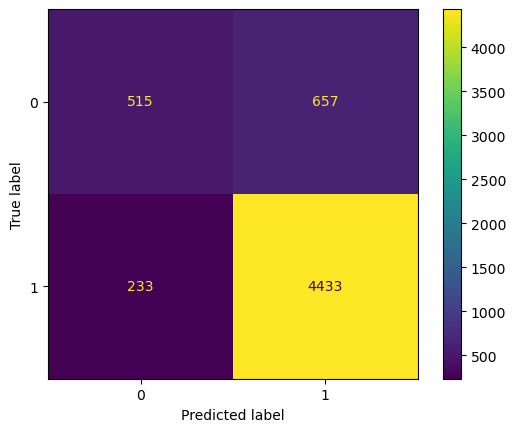

In [ ]:
ConfusionMatrixDisplay.from_predictions(y1_test, y_predicted)

#### Multinomial Naive Bayes

In [ ]:
nb1 = MultinomialNB()

para_grid_nb1 = [
    {'alpha': [1.0e-10, 1, 10, 20, 50, 100]}
]

clf_nb1 = GridSearchCV(nb1, param_grid = para_grid_nb1, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_nb1 = clf_nb1.fit(X, y1)

print(best_clf_nb1.best_score_, best_clf_nb1.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.7558892173669023 MultinomialNB(alpha=1)


In [ ]:
df_best = pd.DataFrame(best_clf_nb1.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.6575931204214843


F1: 0.7585223216487845
Accuracy: 0.8665638917437478


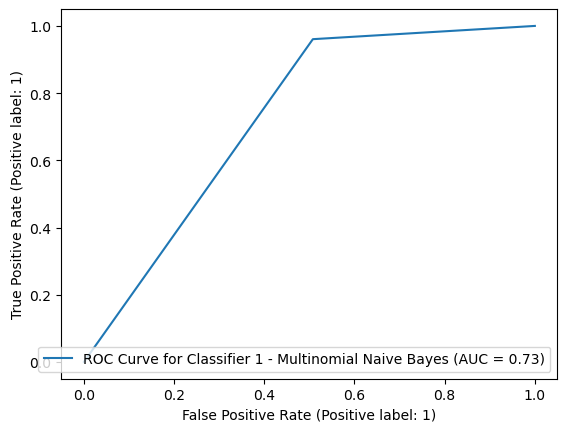

In [ ]:
nb_best1 = best_clf_nb1.best_estimator_
nb_best1.fit(X_train, y1_train)
y_predicted = nb_best1.predict(X_test)

RocCurveDisplay.from_predictions(y1_test, y_predicted, name = "ROC Curve for Classifier 1 - Multinomial Naive Bayes")

print("F1: " + str(f1_score(y1_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y1_test, y_predicted)))

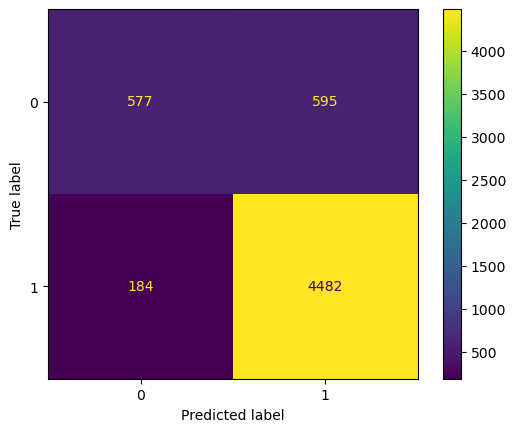

In [ ]:
ConfusionMatrixDisplay.from_predictions(y1_test, y_predicted)

For cut-off 1, the logistic regression model LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear'), with the highest F1 macro validation score of 0.7643, was choosen to proceed to testing on Kaggle. The F1 macro score for testing with this model was 0.7666 on Kaggle, exceeding the baseline score of 0.70.

### 2.2. Binary Classifier 2: 'overall' <= 2 versus 'overall' > 2

In [ ]:
# 'overall' <= 2 labeled as 0, 'overall' >2 labelled as 1
X = vectorizedFeature
df2 = df['overall'].replace([1,2,3,4,5], [0,0,1,1,1])
y2 = df2.to_numpy()

In [ ]:
# Split data for validation after hyperparameter tuning
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size = 0.2, train_size = 0.8)

#### Logistic Regression

In [ ]:
logistic2 = LogisticRegression(solver = 'liblinear')

para_grid_log2 = [
    {'penalty': ['l1','l2', 'none'],
     'C': [1.5, 1.0, 0.1],
    'max_iter': [500, 1000, 5000]}
]

clf_log2 = GridSearchCV(logistic2, param_grid = para_grid_log2, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_log2 = clf_log2.fit(X, y2)

print(best_clf_log2.best_score_, best_clf_log2.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.76829961572285 LogisticRegression(max_iter=500, solver='liblinear')


In [ ]:
# Print mean cross-validation score
df_best = pd.DataFrame(best_clf_log2.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.7615456845294565


F1: 0.7883276266687186
Accuracy: 0.7980472764645427


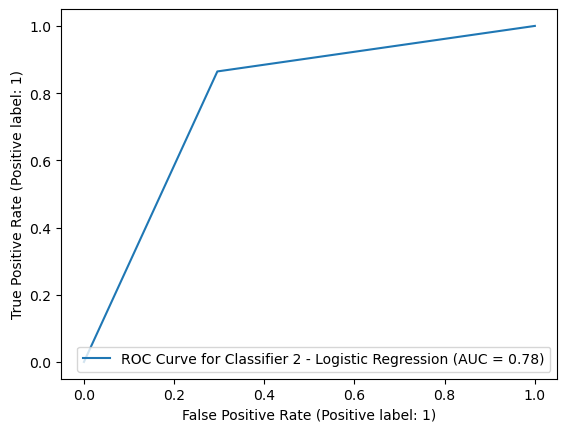

In [ ]:
logistic_best2 = best_clf_log2.best_estimator_
logistic_best2.fit(X_train, y2_train)
y_predicted = logistic_best2.predict(X_test)

RocCurveDisplay.from_predictions(y2_test, y_predicted, name = "ROC Curve for Classifier 2 - Logistic Regression")
print("F1: " + str(f1_score(y2_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y2_test, y_predicted)))

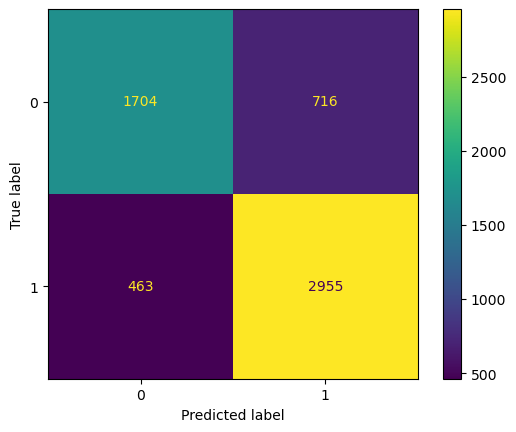

In [ ]:
ConfusionMatrixDisplay.from_predictions(y2_test, y_predicted)

#### Perceptron

In [ ]:
pct2 = Perceptron()

para_grid_pct2 = [
    {'penalty': ['l2','l1', 'elasticnet'],
     'l1_ratio': [0, 0.1, 0.5, 1],
     'max_iter': [500, 1000]}
]

clf_pct2 = GridSearchCV(pct2, param_grid = para_grid_pct2, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_pct2 = clf_pct2.fit(X, y2)

print(best_clf_pct2.best_score_, best_clf_pct2.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.7057141673402049 Perceptron(l1_ratio=0, max_iter=500, penalty='l1')


In [ ]:
# Print mean cross-validation score
df_best = pd.DataFrame(best_clf_pct2.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.6961631927490143


F1: 0.7496490360690415
Accuracy: 0.7682425488180884


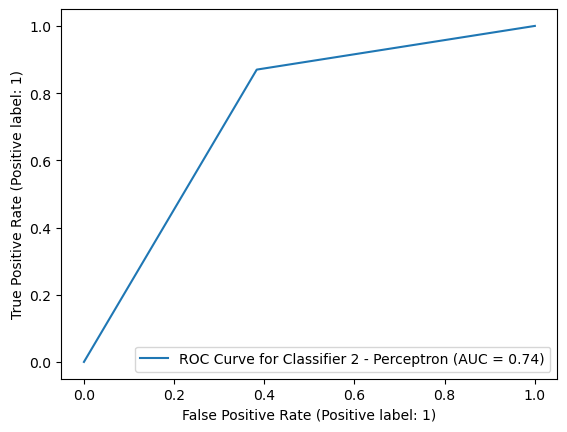

In [ ]:
# Model using the trained hyperparameters
pct_best2 = best_clf_pct2.best_estimator_
pct_best2.fit(X_train, y2_train)
y_predicted = pct_best2.predict(X_test)

RocCurveDisplay.from_predictions(y2_test, y_predicted, name = "ROC Curve for Classifier 2 - Perceptron")
print("F1: " + str(f1_score(y2_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y2_test, y_predicted)))

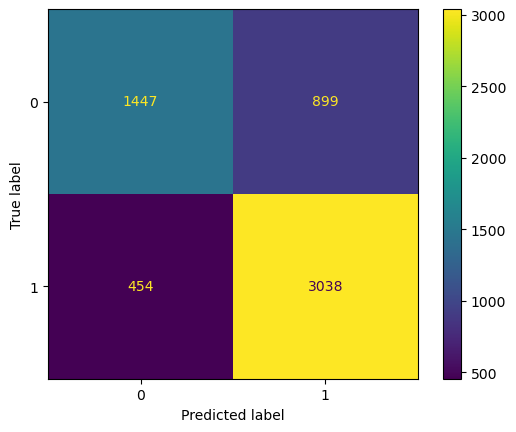

In [ ]:
ConfusionMatrixDisplay.from_predictions(y2_test, y_predicted)

#### Multinomial Naive Bayes

In [ ]:
nb2 = MultinomialNB()

para_grid_nb2 = [
    {'alpha': [1.0e-10, 1, 10, 20, 50, 100]}
]

clf_nb2 = GridSearchCV(nb2, param_grid = para_grid_nb2, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_nb2 = clf_nb2.fit(X, y2)

print(best_clf_nb2.best_score_, best_clf_nb2.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.7650642896685663 MultinomialNB(alpha=1)


In [ ]:
df_best = pd.DataFrame(best_clf_nb2.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.6999123645048426


F1: 0.7670620725058345
Accuracy: 0.7831449126413155


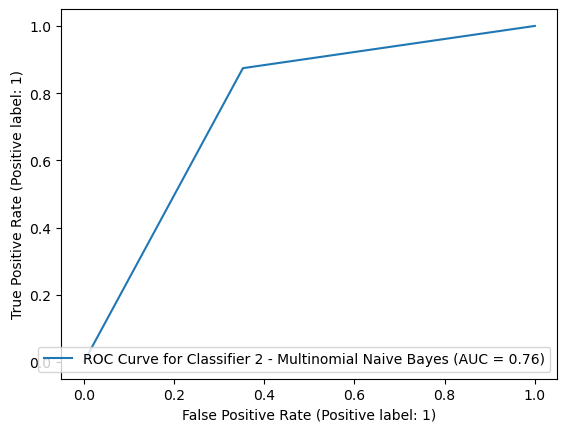

In [ ]:
nb_best2 = best_clf_nb2.best_estimator_
nb_best2.fit(X_train, y2_train)
y_predicted = nb_best2.predict(X_test)

RocCurveDisplay.from_predictions(y2_test, y_predicted, name = "ROC Curve for Classifier 2 - Multinomial Naive Bayes")
print("F1: " + str(f1_score(y2_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y2_test, y_predicted)))

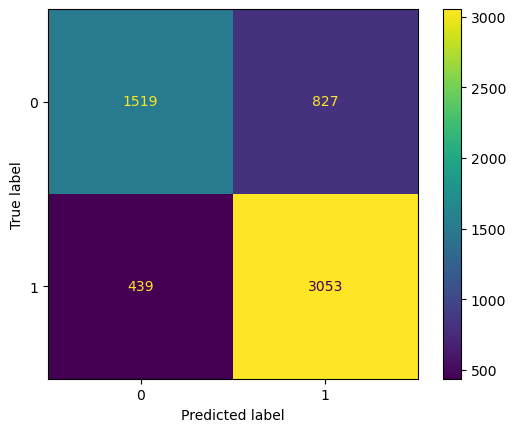

In [ ]:
ConfusionMatrixDisplay.from_predictions(y2_test, y_predicted)

For cut-off 2, the logistic regression model LogisticRegression(max_iter=500, solver='liblinear'), with the highest F1 macro validation score of 0.7899, was choosen to proceed to testing on Kaggle. The F1 macro score for testing with this model was 0.7996 on Kaggle, exceeding the baseline score of 0.78.

### 2.3. Binary Classifier 3: 'overall' <= 3 versus 'overall' > 3

As I found it difficult to reach the 0.80 testing baseline for this task, I resorted to using feature selection on sklearn, which selects the k-most significant x-features that differentiate y-classes from each other.

In [160]:
from sklearn.feature_selection import SelectKBest, f_classif

In [161]:
df3 = df['overall'].replace([1,2,3,4,5], [0,0,0,1,1])
y3 = df3.to_numpy()

In [162]:
# Create a feature selector selecting 1200 best features 
select = SelectKBest(score_func=f_classif, k = 1200)

In [163]:
# Vectorize reviewText and select 1200 best features
vectorizer3 = TfidfVectorizer(stop_words = 'english', max_features = 6000)
vectorizedReview_1 = vectorizer3.fit_transform(df['reviewText']).toarray()
selectedReview = select.fit_transform(vectorizedReview_1, y3)

In [164]:
# Vectorize summaryText and select 1200 best features
vectorizer4 = TfidfVectorizer(stop_words = 'english', max_features = 6000)
vectorizedSummary_1 = vectorizer4.fit_transform(df['summary'].values.astype('U')).toarray()
selectedSummary = select.fit_transform(vectorizedSummary_1, y3)

In [165]:
features = np.concatenate((selectedReview, selectedSummary), axis = 1)

In [171]:
X_1 = features
X3_train, X3_test, y3_train, y3_test = train_test_split(X_1, y3, test_size = 0.2, train_size = 0.8)

#### Logistic Regression

In [172]:
logistic3 = LogisticRegression(solver = 'liblinear')

para_grid_log3 = [
    {'penalty': ['l1','l2', 'none'],
     'C': [1.5, 1.0, 0.1],
    'max_iter': [500, 1000, 5000]}
]

clf_log3 = GridSearchCV(logistic3, param_grid = para_grid_log3, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_log3 = clf_log3.fit(X_1, y3)

print(best_clf_log3.best_score_, best_clf_log3.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.7992932699213868 LogisticRegression(C=1.5, max_iter=500, solver='liblinear')


In [173]:
df_best = pd.DataFrame(best_clf_log3.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.7656207136090092


F1: 0.8231019409417595
Accuracy: 0.8345323741007195


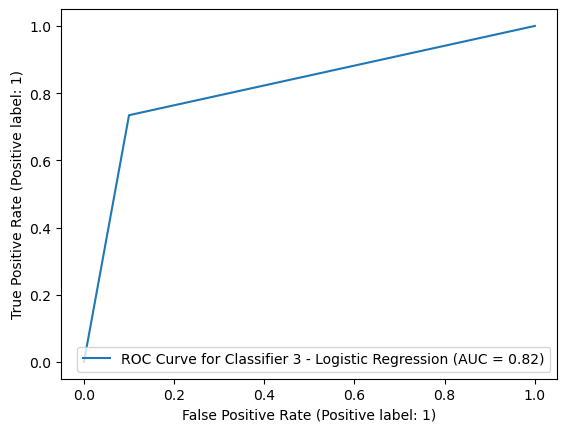

In [174]:
logistic_best3 = best_clf_log3.best_estimator_
logistic_best3.fit(X3_train, y3_train)
y_predicted = logistic_best3.predict(X3_test)

RocCurveDisplay.from_predictions(y3_test, y_predicted, name = "ROC Curve for Classifier 3 - Logistic Regression")
print("F1: " + str(f1_score(y3_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y3_test, y_predicted)))

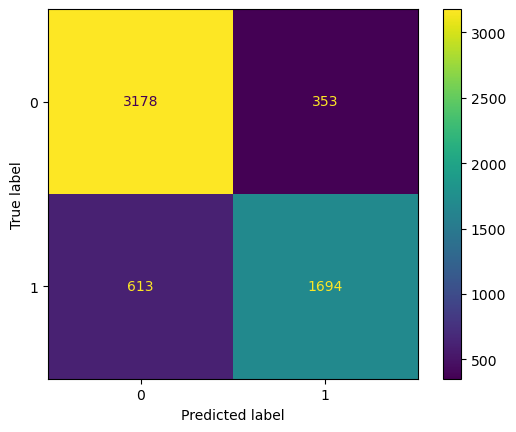

In [175]:
ConfusionMatrixDisplay.from_predictions(y3_test, y_predicted)

#### Perceptron

In [176]:
pct3 = Perceptron()

para_grid_pct3 = [
    {'penalty': ['l2','l1', 'elasticnet'],
     'l1_ratio': [0, 0.1, 0.5, 1],
     'max_iter': [500, 1000]}
]

clf_pct3 = GridSearchCV(pct3, param_grid = para_grid_pct3, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_pct3 = clf_pct3.fit(X_1, y3)

print(best_clf_pct3.best_score_, best_clf_pct3.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.6996382629576434 Perceptron(l1_ratio=0, max_iter=500, penalty='l1')


In [177]:
df_best = pd.DataFrame(best_clf_pct3.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.6838527579468665


F1: 0.6482875818024225
Accuracy: 0.7199383350462487


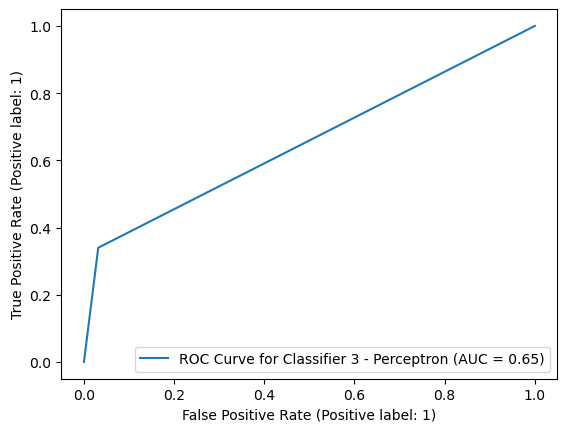

In [178]:
pct_best3 = best_clf_pct3.best_estimator_
pct_best3.fit(X3_train, y3_train)
y_predicted = pct_best3.predict(X3_test)

RocCurveDisplay.from_predictions(y3_test, y_predicted, name = "ROC Curve for Classifier 3 - Perceptron")
print("F1: " + str(f1_score(y3_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y3_test, y_predicted)))

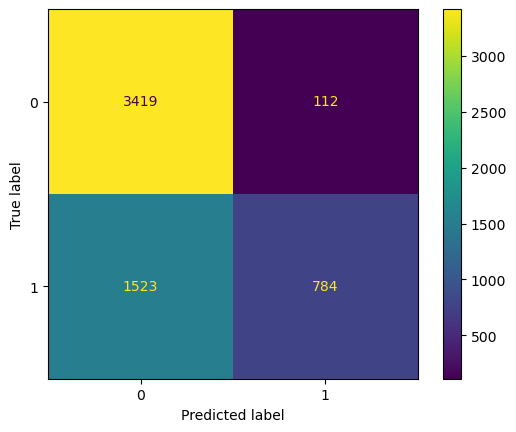

In [179]:
ConfusionMatrixDisplay.from_predictions(y3_test, y_predicted)

#### Multinomial Naive Bayes

In [180]:
nb3 = MultinomialNB()

para_grid_nb3 = [
    {'alpha': [1.0e-10, 1, 10, 20, 50, 100]}
]

clf_nb3 = GridSearchCV(nb3, param_grid = para_grid_nb3, cv = 5, verbose = 1, n_jobs = -1, scoring = "f1_macro")
best_clf_nb3 = clf_nb3.fit(X_1, y3)

print(best_clf_nb3.best_score_, best_clf_nb3.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.8029166948111813 MultinomialNB(alpha=1e-10)


In [181]:
df_best = pd.DataFrame(best_clf_nb3.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.7023686725947728


F1: 0.8142613814955525
Accuracy: 0.8251113394998287


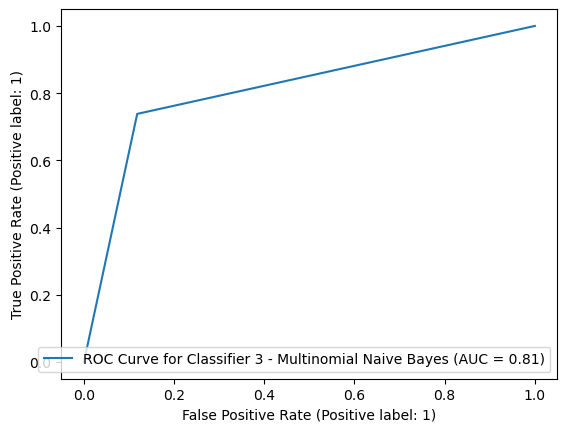

In [182]:
nb_best3 = best_clf_nb3.best_estimator_
nb_best3.fit(X3_train, y3_train)
y_predicted = nb_best3.predict(X3_test)

RocCurveDisplay.from_predictions(y3_test, y_predicted, name = "ROC Curve for Classifier 3 - Multinomial Naive Bayes")
print("F1: " + str(f1_score(y3_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y3_test, y_predicted)))

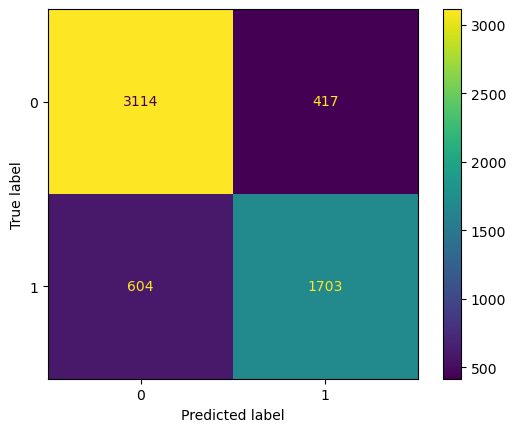

In [183]:
ConfusionMatrixDisplay.from_predictions(y3_test, y_predicted)

For cut-off 3, the logistic regression model LogisticRegression(C=1.5, max_iter=500, penalty='l1', solver='liblinear'), with the highest F1 macro validation score of 0.7903, was choosen to proceed to testing on Kaggle. The F1 macro score for testing with this model was 0.7898 on Kaggle, not exceeding the baseline score of 0.80.

### 2.4. Binary Classifier 4: 'overall' <= 4 versus 'overall' > 4

In [ ]:
# 'overall' <= 4 labeled as 0, 'overall' > 4 labelled as 1
X = vectorizedFeature
df4 = df['overall'].replace([1,2,3,4,5], [0,0,0,0,1])
y4 = df4.to_numpy()

# Split data for validation after hyperparameter tuning
X_train, X_test, y4_train, y4_test = train_test_split(X, y4, test_size = 0.2, train_size = 0.8)

#### Logistic Regression

In [ ]:
logistic4 = LogisticRegression(solver = 'liblinear')

para_grid_log4 = [
    {'penalty': ['l1','l2', 'none'],
     'C': [1.5, 1.0, 0.1],
    'max_iter': [500, 1000, 5000]}
]

clf_log4 = GridSearchCV(logistic4, param_grid = para_grid_log4, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_log4 = clf_log4.fit(X, y4)

print(best_clf_log4.best_score_, best_clf_log4.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.7124392250934412 LogisticRegression(C=1.5, max_iter=500, penalty='l1', solver='liblinear')


In [ ]:
df_best = pd.DataFrame(best_clf_log4.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.6774447032811828


F1: 0.7147900468085995
Accuracy: 0.8487495717711545


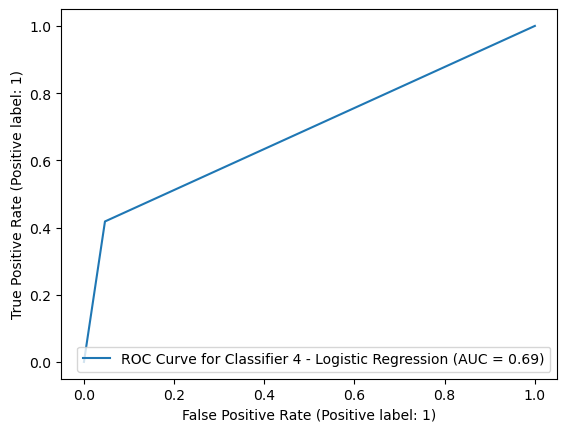

In [ ]:
logistic_best4 = best_clf_log4.best_estimator_
logistic_best4.fit(X_train, y4_train)
y_predicted = logistic_best4.predict(X_test)

RocCurveDisplay.from_predictions(y4_test, y_predicted, name = "ROC Curve for Classifier 4 - Logistic Regression")
print("F1: " + str(f1_score(y4_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y4_test, y_predicted)))

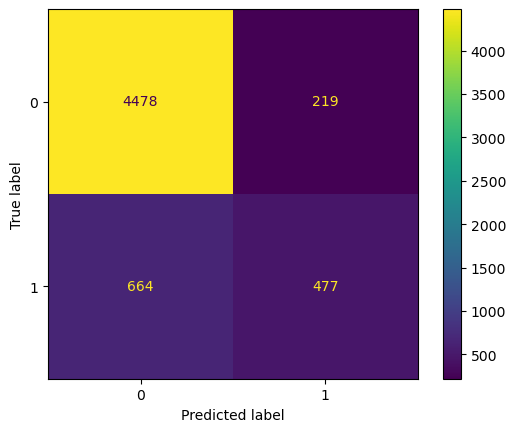

In [ ]:
ConfusionMatrixDisplay.from_predictions(y4_test, y_predicted)

#### Perceptron

In [ ]:
pct4 = Perceptron()

para_grid_pct4 = [
    {'penalty': ['l2','l1', 'elasticnet'],
     'l1_ratio': [0, 0.1, 0.5, 1],
     'max_iter': [500, 1000]}
]

clf_pct4 = GridSearchCV(pct4, param_grid = para_grid_pct4, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_pct4 = clf_pct4.fit(X, y4)

print(best_clf_pct4.best_score_, best_clf_pct4.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.6531806083763618 Perceptron(l1_ratio=0, max_iter=500, penalty='l2')


In [ ]:
df_best = pd.DataFrame(best_clf_pct4.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.6364994474288042


F1: 0.6031017877728729
Accuracy: 0.8257965056526207


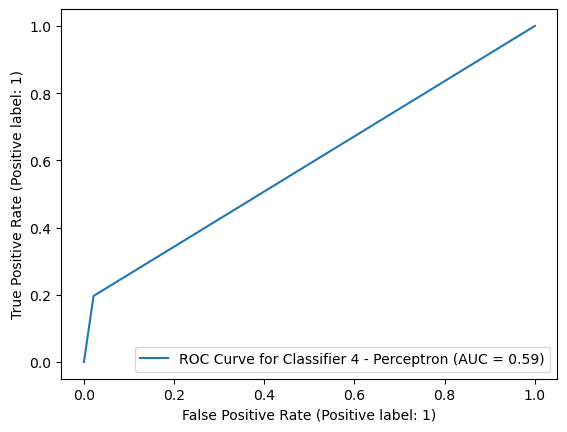

In [ ]:
pct_best4 = best_clf_pct4.best_estimator_
pct_best4.fit(X_train, y4_train)
y_predicted = pct_best4.predict(X_test)

RocCurveDisplay.from_predictions(y4_test, y_predicted, name = "ROC Curve for Classifier 4 - Perceptron")
print("F1: " + str(f1_score(y4_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y4_test, y_predicted)))

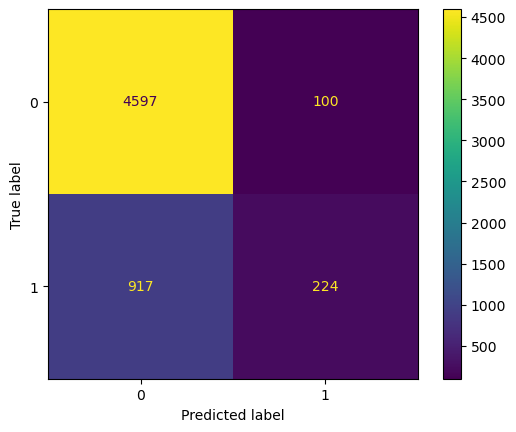

In [ ]:
ConfusionMatrixDisplay.from_predictions(y4_test, y_predicted)

#### Multinomial Naive Bayes

In [ ]:
nb4 = MultinomialNB()

para_grid_nb4 = [
    {'alpha': [1.0e-10, 1, 10, 20, 50, 100]}
]

clf_nb4 = GridSearchCV(nb4, param_grid = para_grid_nb4, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_nb4 = clf_nb4.fit(X, y4)

print(best_clf_nb4.best_score_, best_clf_nb4.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.6846153744186433 MultinomialNB(alpha=1e-10)


In [ ]:
df_best = pd.DataFrame(best_clf_nb4.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.5399617086929787


F1: 0.6913965145439158
Accuracy: 0.8398424117848579


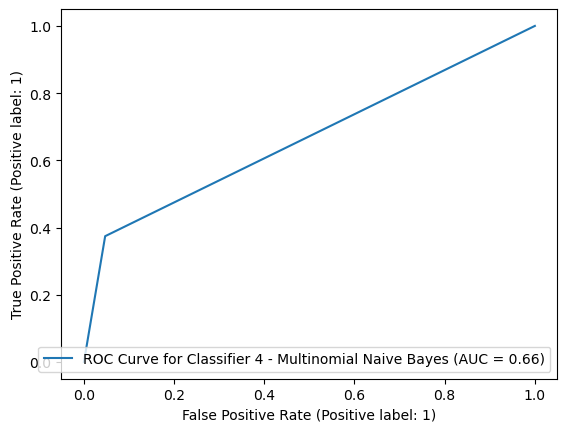

In [ ]:
nb_best4 = best_clf_nb4.best_estimator_
nb_best4.fit(X_train, y4_train)
y_predicted = nb_best4.predict(X_test)

RocCurveDisplay.from_predictions(y4_test, y_predicted, name = "ROC Curve for Classifier 4 - Multinomial Naive Bayes")
print("F1: " + str(f1_score(y4_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y4_test, y_predicted)))

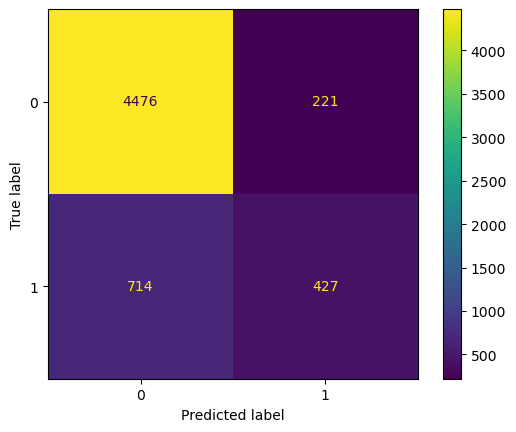

In [ ]:
ConfusionMatrixDisplay.from_predictions(y4_test, y_predicted)

For cut-off 4, the logistic regression LogisticRegression(C=1.5, max_iter=500, penalty='l1', solver='liblinear'), with the highest F1 macro validation score of 0.7124, was choosen to proceed to testing on Kaggle. The F1 macro score for testing with this model was 0.7071 on Kaggle, not exceeding the baseline score of 0.70.

### 2.5. Multiclass Classifier

In [ ]:
X = vectorizedFeature
y5 = df['overall']
X_train, X_test, y5_train, y5_test = train_test_split(X, y5, test_size = 0.2, train_size = 0.8)

#### Method to plot multiple ROC curves for one-versus-all multiclass classifiers

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [ ]:
def plot_roc_curve(y_test, y_pred, model):
    n_class = 5
    classes=[1,2,3,4,5]
    y_test_binarized = label_binarize(y_test, classes = classes )
    y_pred_binarized = label_binarize(y_pred, classes = classes)
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC curve and ROC area for each class and plot them
    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.plot(fpr[i], tpr[i], linestyle = '--', label = '%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))
    
    # Find micro average to get average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot average curve using micro average 
    plt.plot(fpr["micro"], tpr["micro"], label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]), color="deeppink", linestyle=":", linewidth=4,)

        
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curve) - " + model)
    plt.legend()

#### Logistic Regression

In [ ]:
logistic5 = LogisticRegression(solver = 'liblinear', multi_class = 'ovr')

para_grid_log5 = [
    {'penalty': ['l1','l2', 'None'],
     'C': [100, 10, 1.0, 0.1],
    'max_iter': [5000, 10000]
    }
]

clf_log5 = GridSearchCV(logistic5, param_grid = para_grid_log5, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_log5 = clf_log5.fit(X, y5)

print(best_clf_log5.best_score_, best_clf_log5.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.4731638869729003 LogisticRegression(max_iter=10000, multi_class='ovr', penalty='l1',
                   solver='liblinear')


In [ ]:
df_best = pd.DataFrame(best_clf_log5.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.4440206294706261


In [ ]:
logistic_best5 = best_clf_log5.best_estimator_
logistic_best5.fit(X_train, y5_train)
y_predicted = logistic_best5.predict(X_test)

print("F1: " + str(f1_score(y5_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y5_test, y_predicted)))

F1: 0.47515711182977044
Accuracy: 0.47978759849263447


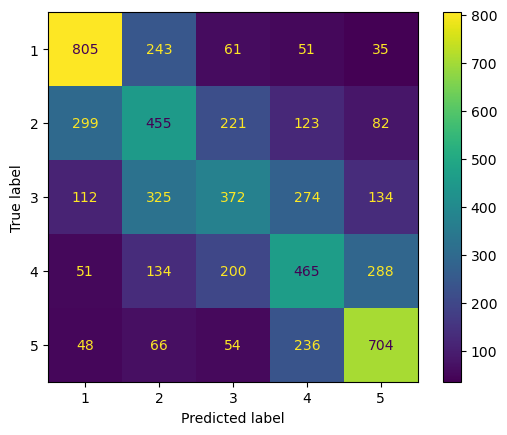

In [ ]:
ConfusionMatrixDisplay.from_predictions(y5_test, y_predicted)

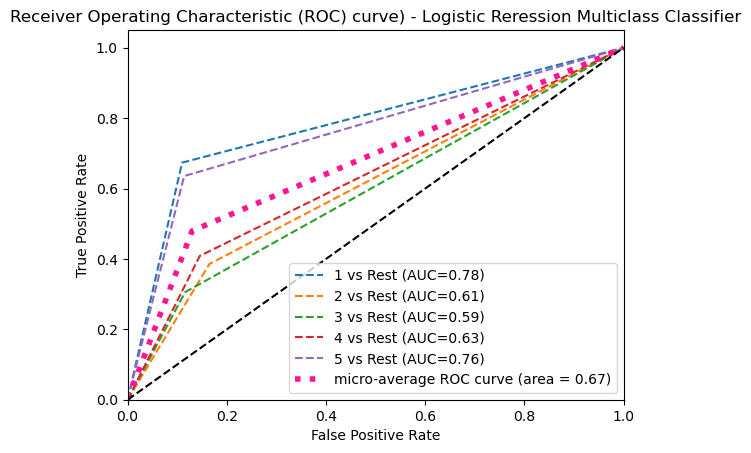

In [ ]:
plot_roc_curve(y5_test, y_predicted, "Logistic Reression Multiclass Classifier")

#### Perceptron

In [ ]:
pct5 = Perceptron()

para_grid_pct5 = [
    {'penalty': ['l2','l1', 'elasticnet'],
     'l1_ratio': [0, 0.1, 0.5, 1],
     'max_iter': [500, 1000]}
]

clf_pct5 = GridSearchCV(pct5, param_grid = para_grid_pct5, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_pct5 = clf_pct5.fit(X, y4)

print(best_clf_pct5.best_score_, best_clf_pct5.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.6531806083763618 Perceptron(l1_ratio=0, max_iter=500, penalty='l2')


In [ ]:
df_best = pd.DataFrame(best_clf_pct5.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.6364994474288042


In [ ]:
pct_best5 = best_clf_pct5.best_estimator_
pct_best5.fit(X_train, y5_train)
y_predicted = pct_best5.predict(X_test)

print("F1: " + str(f1_score(y5_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y5_test, y_predicted)))

F1: 0.37250279853227247
Accuracy: 0.3778691332648167


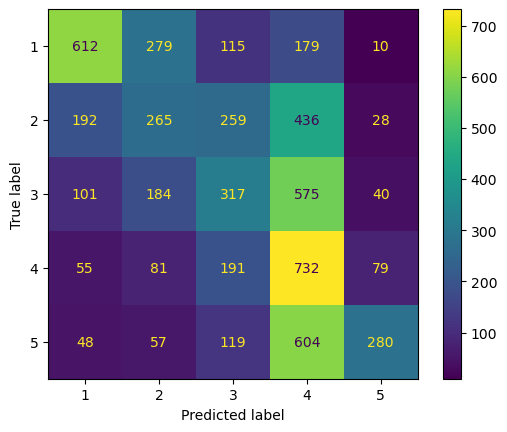

In [ ]:
ConfusionMatrixDisplay.from_predictions(y5_test, y_predicted)

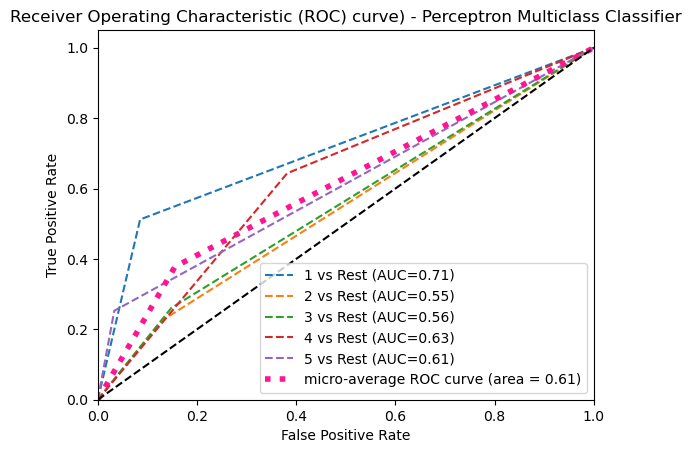

In [ ]:
plot_roc_curve(y5_test, y_predicted, "Perceptron Multiclass Classifier")

#### Multinomial Naive Bayes

In [ ]:
nb5 = MultinomialNB()

para_grid_nb5 = [
    {'alpha': [1.0e-10, 1, 10, 20, 50, 100]}
]

clf_nb5 = GridSearchCV(nb5, param_grid = para_grid_nb5, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
best_clf_nb5 = clf_nb5.fit(X, y5)

print(best_clf_nb5.best_score_, best_clf_nb5.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.4668451348486151 MultinomialNB(alpha=10)


In [ ]:
df_best = pd.DataFrame(best_clf_nb5.cv_results_)
print("Average cross-validation F1 score for all combinations:" + str(df_best.loc[:, 'mean_test_score'].mean()))

Average cross-validation F1 score for all combinations:0.45426348346420947


In [ ]:
nb_best5 = best_clf_nb5.best_estimator_
nb_best5.fit(X_train, y5_train)
y_predicted = nb_best5.predict(X_test)

print("F1: " + str(f1_score(y5_test, y_predicted, average = 'macro')))
print("Accuracy: " + str(accuracy_score(y5_test, y_predicted)))

F1: 0.4741451955633275
Accuracy: 0.4791024323398424


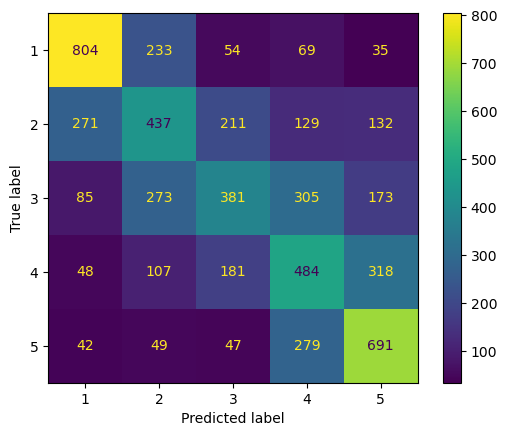

In [ ]:
ConfusionMatrixDisplay.from_predictions(y5_test, y_predicted)

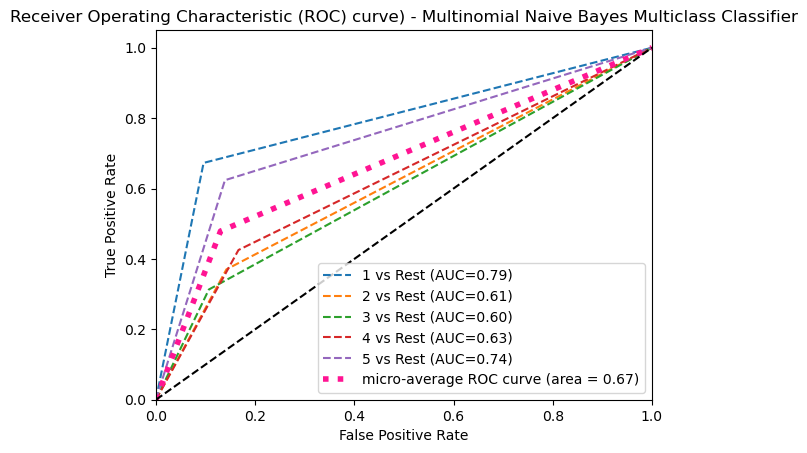

In [ ]:
plot_roc_curve(y5_test, y_predicted, "Multinomial Naive Bayes Multiclass Classifier")

For the multiclass classifier, the logistic regression LogisticRegression(max_iter=10000, multi_class='ovr', penalty='l1', solver='liblinear'), with the highest F1 macro validation score of 0.4732, was choosen to proceed to testing on Kaggle. The F1 macro score for testing with this model was 0.4879 on Kaggle, not exceeding the baseline score of 0.47.

### 3. Clustering with K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score

In [ ]:
# Import test data
data_test = pd.read_csv("Test.csv")
df_test = pd.DataFrame(data_test)

# Convert reviewText and summary to lower case
df_test.loc[:, 'reviewText'] = df_test['reviewText'].str.lower()
df_test.loc[:, 'summary'] = df_test['summary'].str.lower()

# Remove punctuations for reviewText and summary
df_test['reviewText']=df_test['reviewText'].str.replace('[^\w\s]','')
df_test['summary']=df_test['summary'].str.replace('[^\w\s]','')

In [ ]:
# Vectorize reviewText and summary
vectorizer1 = TfidfVectorizer(stop_words = 'english', min_df = 0.1, max_features = 3000)
vectorizedReview_test = vectorizer1.fit_transform(df_test['reviewText']).toarray()

vectorizer2 = TfidfVectorizer(stop_words = 'english', min_df = 0.1, max_features = 2500)
vectorizedSummary_test = vectorizer2.fit_transform(df_test['summary'].values.astype('U')).toarray()

clusterFeature = np.concatenate((vectorizedReview_test, vectorizedSummary_test), axis =1)

In [ ]:
# Plot the sum of squared distances for k values ranging from 1 to 100 to use the elbow method
Sum_of_squared_distances = []
K_range = range(1,101)
    
for num_clusters in K_range:
    kmeans = KMeans(n_clusters=num_clusters, max_iter = 500)
    kmeans.fit(clusterFeature)
    Sum_of_squared_distances.append(kmeans.inertia_)

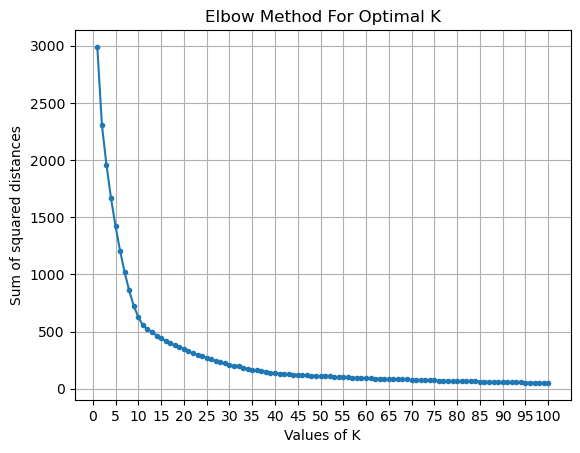

In [ ]:
plt.plot(K_range,Sum_of_squared_distances, marker='o', markersize= 3)
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances") 
plt.title("Elbow Method For Optimal K")
plt.xticks(np.arange(0,101,5))
plt.grid()
plt.show()

From the figure above, we see that the "elbow" occurs when k = 11. The elbow method tells us that this is the optimal K for this clustering task.

In [ ]:
# Method to calculate silhoutte score and Rand index for the optimal k = 11
best_kmeans =  KMeans(n_clusters= 11, max_iter = 500)
best_kmeans.fit_predict(clusterFeature)
silhoutte = silhouette_score(clusterFeature, best_kmeans.labels_)
rand = rand_score(df_test["category"], best_kmeans.labels_)

print("The silhouette score is " + str(silhoutte))
print("The Rand index is " + str(rand))

The silhouette score is 0.6681163784305004
The Rand index is 0.7424195994171544


The silhoutte score passes the baseline score. 